In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import DatasetDict
from transformers import DataCollatorForTokenClassification
from transformers import AutoTokenizer
from collections import Counter
import matplotlib.pyplot as plt

from src.configuration.set_up_config_device import (
    get_allowed_cpu_count,
    set_up_config_device,
    set_up_device,
)
from src.data_processing.loading import load_iob_data
from src.data_processing.tokenization import create_tokenized_dataset
from src.data_processing.descriptive_statistics import descriptive_statistics
from src.model.transformer import (
    Transformer,
    TransformerForNER,
)
from src.model.train import (
    train_model,
    plot_train_val_loss,
)
from src.evaluate.evaluate import evaluate_ner_model

In [3]:
device = set_up_device()
cpu_count = get_allowed_cpu_count()
n_process = set_up_config_device(cpu_count)

2025-04-11 13:38:14 - INFO - Using cuda device
2025-04-11 13:38:14 - INFO - Using 104 CPUs
2025-04-11 13:38:14 - INFO - torch set up to use 52 processes


In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", add_prefix_space=True)

In [5]:
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
NB_EPOCHS = 1

In [6]:
MODEL_PARAMETERS = {
    "pad_idx": tokenizer.pad_token_id,
    "vocab_size": tokenizer.vocab_size,
    "hidden_size": 256,
    "n_head": 4,
    "max_len": 512,
    "ffn_hidden": 512,
    "n_layers": 4,
}

# **LOAD & PROCESS DATA**

In [7]:
sentences, labels = load_iob_data("data/raw/train-nl.tsv")

In [8]:
tokenized_dataset = create_tokenized_dataset(
    sentences, labels, save_path="data/tokenized/tokenized_dataset.json"
)

Creating json from Arrow format: 100%|██████████| 3/3 [00:00<00:00,  4.68ba/s]

Tokenized dataset saved at: data/tokenized/tokenized_dataset.json


In [9]:
# Split train/test
train_test = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# Split test into validation/test
val_test = train_test["test"].train_test_split(test_size=0.5, seed=42)

# Recombine into final DatasetDict
split_dataset = DatasetDict(
    {
        "train": train_test["train"],
        "validation": val_test["train"],
        "test": val_test["test"],
    }
)

In [10]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1759
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 220
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 220
    })
})

In [11]:
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer, padding=True, max_length=512, return_tensors="pt"
)

train_dataset = split_dataset["train"].remove_columns(["tokens", "ner_tags"])
val_dataset = split_dataset["validation"].remove_columns(["tokens", "ner_tags"])

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=data_collator)

# **DESCRIPTIVE STATISTICS**

In [12]:
descriptive_statistics(sentences, labels)

Corpus Summary:
   num_sentences  min_length  mean_length  max_length
0           2199           1   227.498863         703

IOB Tag Statistics (per sentence):
                                 min        mean    max  n_unique_words
B-Organization                   0.0    0.483856    7.0           258.0
B-Organization,B-Place           0.0    0.001364    1.0             2.0
B-Organization,I-Person          0.0    0.001819    2.0             3.0
B-Organization,I-Place           0.0    0.016371    2.0            14.0
B-Person                         0.0    5.238290   47.0          3501.0
B-Person,B-Place                 0.0    0.000910    1.0             2.0
B-Person,I-Place                 0.0    0.011369    1.0             9.0
B-Place                          0.0    1.858572   12.0          1081.0
I-Organization                   0.0    1.435198   25.0           777.0
I-Organization,B-Place           0.0    0.135516    3.0           119.0
I-Organization,I-Person          0.0    0.005912

# **DEFINE & TRAIN MODEL**

In [13]:
all_labels = [
    label for example in split_dataset["train"] for label in example["ner_tags"]
]
unique_ids = sorted(set(all_labels))
label2id = {i: i for i in range(num_labels)}

In [15]:
model = TransformerForNER(**MODEL_PARAMETERS, num_labels=len(label2id)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [16]:
train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    epochs=NB_EPOCHS,
    save_path="checkpoints/best_model.pt",
)

/opt/conda/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch 1/50 - Train Loss: 1.0322 | Val Loss: 0.5381
Epoch 2/50 - Train Loss: 0.5240 | Val Loss: 0.4967
Epoch 3/50 - Train Loss: 0.4908 | Val Loss: 0.4712
Epoch 4/50 - Train Loss: 0.4694 | Val Loss: 0.4511
Epoch 5/50 - Train Loss: 0.4536 | Val Loss: 0.4396
Epoch 6/50 - Train Loss: 0.4405 | Val Loss: 0.4330
Epoch 7/50 - Train Loss: 0.4294 | Val Loss: 0.4191
Epoch 8/50 - Train Loss: 0.4192 | Val Loss: 0.4100
Epoch 9/50 - Train Loss: 0.4120 | Val Loss: 0.4066
Epoch 10/50 - Train Loss: 0.4045 | Val Loss: 0.3985
Epoch 11/50 - Train Loss: 0.3974 | Val Loss: 0.3907
Epoch 12/50 - Train Loss: 0.3924 | Val Loss: 0.3869
Epoch 13/50 - Train Loss: 0.3871 | Val Loss: 0.3836
Epoch 14/50 - Train Loss: 0.3818 | Val Loss: 0.3825
Epoch 15/50 - Train Loss: 0.3769 | Val Loss: 0.3763
Epoch 16/50 - Train Loss: 0.3739 | Val Loss: 0.3719
Epoch 17/50 - Train Loss: 0.3691 | Val Loss: 0.3759
Epoch 18/50 - Train Loss: 0.3659 | Val Loss: 0.3727
Epoch 19/50 - Train Loss: 0.3623 | Val Loss: 0.3678
Epoch 20/50 - Train L

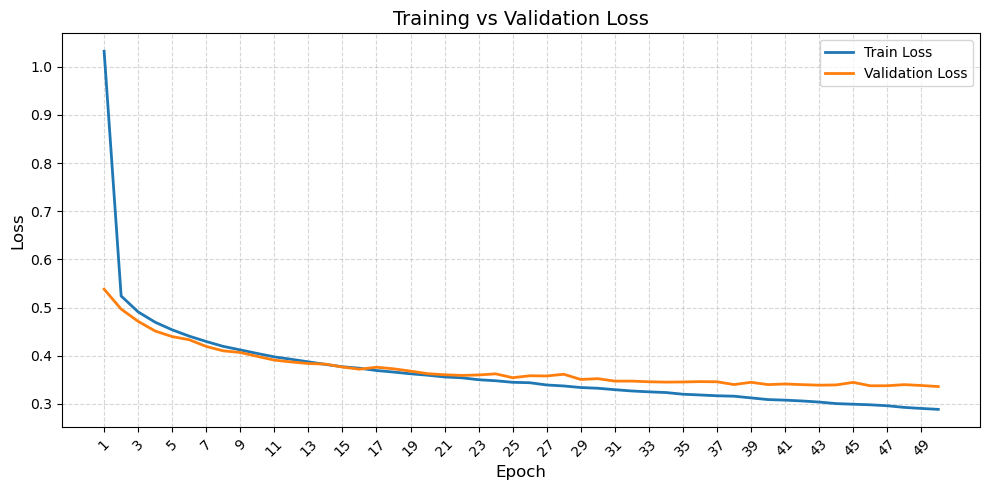

In [21]:
plot_train_val_loss(train_losses, val_losses, title="Training vs Validation Loss")

# **EVALUATE RESULTS**

In [33]:
test_dataset = split_dataset["test"].remove_columns(["tokens", "ner_tags"])

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=data_collator)

In [34]:
unique_labels = sorted(set(label for sent in labels for label in sent))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

In [35]:
evaluate_ner_model(model, test_loader, id2label, device=device)

🔍 seqeval classification report:
                      precision    recall  f1-score   support

        Organization     0.0357    0.0133    0.0194        75
Organization,B-Place     0.0000    0.0000    0.0000        29
Organization,I-Place     0.3333    0.0588    0.1000        17
              Person     0.1240    0.1902    0.1501       915
      Person,B-Place     1.0000    0.0769    0.1429        13
      Person,I-Place     0.0000    0.0000    0.0000         6
               Place     0.2692    0.1909    0.2234       330

           micro avg     0.1437    0.1733    0.1571      1385
           macro avg     0.2518    0.0757    0.0908      1385
        weighted avg     0.1615    0.1733    0.1560      1385


F1-score (micro): 0.1571
